In [28]:
import os
import json
import pandas as pd

In [29]:
data_dir = '/mnt/nas2/GrimaRepo/datasets/20BN-SOMETHING-SOMETHING-V2'

In [30]:
prefix = 'something-something-v2-'
labels_json = json.load(open(os.path.join(data_dir, prefix + 'labels.json'), encoding='utf8'))
train_json = json.load(open(os.path.join(data_dir, prefix + 'train.json'), encoding='utf8'))
val_json = json.load(open(os.path.join(data_dir, prefix + 'validation.json'), encoding='utf8'))
test_json = json.load(open(os.path.join(data_dir, prefix + 'test.json'), encoding='utf8'))

In [31]:
def get_df(json_data):
    data = []
    for json_elem in json_data:
        video_id = json_elem['id']
        class_name = json_elem['template'].replace('[', '').replace(']', '')
        label = int(labels_json[class_name])
        data.append([video_id, label])
    df = pd.DataFrame(data, columns=['video_id', 'label'])
    
    return df

In [32]:
train_df = get_df(train_json)
val_df = get_df(val_json)
# test_df = get_df(test_json)

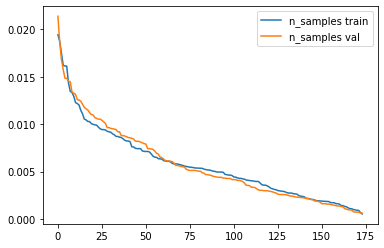

In [33]:
# Plot number of samples by split

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

a = np.array(train_df.groupby('label')['video_id'].count().sort_values(ascending=False).tolist()) / len(train_json)
b = np.array(val_df.groupby('label')['video_id'].count().sort_values(ascending=False).tolist()) / len(val_json)

ap, = plt.plot(a)
bp, = plt.plot(b)
plt.legend([ap, bp], ['n_samples train', 'n_samples val'])

In [34]:
train_id_to_label = train_df.set_index('video_id')
val_id_to_label = val_df.set_index('video_id')

In [35]:
n_train = train_df.count()['label']
n_train_sample = int(.1 * n_train)
# n_train_sample = 100

In [43]:
labels_by_size = train_df.groupby('label')['video_id'].count().sort_values(ascending=False)
# Only get classes with less than 1000 samples
labels_by_size = labels_by_size[labels_by_size <= 1000]
sample_size = 0
sample_labels = []
for label, size in labels_by_size.iteritems():
    sample_size += size
    sample_labels.append(label)
    if sample_size >= n_train_sample:
        break
sample_labels = sorted(sample_labels)

In [37]:
from tqdm import tqdm
def get_sample_json(original_json, original_id_to_label):
    sample_json = []
    for json_elem in tqdm(original_json):
        video_id = json_elem['id']
        label = original_id_to_label.loc[video_id]['label']
        if label in sample_labels:
            sample_json.append(json_elem)
    return sample_json

In [38]:
sample_train_json = get_sample_json(train_json, train_id_to_label)
sample_val_json = get_sample_json(val_json, val_id_to_label)

100%|██████████| 24777/24777 [00:05<00:00, 4584.68it/s]


In [57]:
sample_labels_json = {}
label_i = 0
sorted_labels_json = sorted(map(lambda x: (x[0], int(x[1])), labels_json.items()), key=lambda x: x[1])
for label_name, label in sorted_labels_json:
    if label in sample_labels:
        sample_labels_json[label_name] = str(label_i)
        label_i += 1

In [58]:
print('Original')
print('Number of classes:', len(labels_json))
print('Train size:', len(train_json))
print('Val size:', len(val_json))

print()

print('Sample')
print('Number of classes:', len(sample_labels))
print('Train size:', len(sample_train_json))
print('Val size:', len(sample_val_json))

Original
Number of classes: 174
Train size: 168913
Val size: 24777

Sample
Number of classes: 18
Train size: 16923
Val size: 2547


In [59]:
SAVE_SUFFIX = '10percent'

In [61]:
json.dump(sample_train_json, open('train_{}.json'.format(SAVE_SUFFIX), 'w'))
json.dump(sample_val_json, open('val_{}.json'.format(SAVE_SUFFIX), 'w'))
json.dump(sample_labels_json, open('labels_{}.json'.format(SAVE_SUFFIX), 'w'))

In [64]:
label_to_name = {}
for name, label in labels_json.items():
    label_to_name[int(label)] = name
    
with open('label_names_{}.txt'.format(SAVE_SUFFIX), 'w') as f:
    for label in sample_labels:
        f.write('{}\n'.format(label_to_name[label]))